<a href="https://colab.research.google.com/github/mario-rot/ComputerVisionCourse-MAI/blob/main/Session%2011/P11_Mario_Lauren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory #5_2 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%shell
git clone https://github.com/mario-rot/ComputerVisionCourse-MAI.git
cd 'ComputerVisionCourse-MAI'
mv 'Session 11/TrayDataset' /content/
mv 'customplots.py' /content/
mv 'utils.py' /content/

Cloning into 'ComputerVisionCourse-MAI'...
remote: Enumerating objects: 14871, done.
remote: Counting objects: 100% (3292/3292), done.
remote: Compressing objects: 100% (3037/3037), done.
remote: Total 14871 (delta 239), reused 3270 (delta 226), pack-reused 11579
Receiving objects: 100% (14871/14871), 168.44 MiB | 30.31 MiB/s, done.
Resolving deltas: 100% (242/242), done.
Checking out files: 100% (14430/14430), done.


In [135]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras.utils import load_img
from PIL.ImageOps import autocontrast

# Constants

*   Change the path of the directories according to your drive location.

In [136]:
root_path = r'/content/TrayDataset/'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

*   Define the constants needed for training the model

In [137]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [138]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

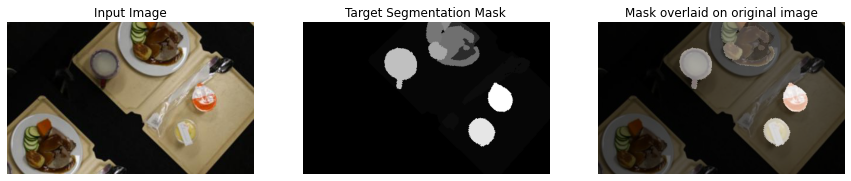

In [139]:
# solution

f, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(load_img(train_img_paths[9]))
axes[0].set_title('Input Image')
axes[0].axis('off')

# Display auto-contrast version of corresponding target (per-pixel categories)
axes[1].imshow(autocontrast(load_img(train_mask_paths[9])))
axes[1].set_title('Target Segmentation Mask')
axes[1].axis('off')

# Overlaid images
axes[2].imshow(load_img(train_img_paths[9]))
axes[2].imshow(autocontrast(load_img(train_mask_paths[9])), alpha=0.6)
axes[2].set_title('Mask overlaid on original image')
axes[2].axis('off')


plt.show()

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [140]:
# solution

class ImageGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] -= 1
        return x, y


# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [141]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model
    

In [142]:
# Free up RAM in case the model definition cells were run multiple times

import keras
keras.backend.clear_session()

In [143]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [144]:
# solution

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [145]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)

val_gen = ImageGenerator(8, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [146]:
# solution

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

*   Instantiate a ModelCheckpoint callback to save only the best model

In [147]:
# solution

callbacks = [
    keras.callbacks.ModelCheckpoint("tray_segmentation.h5", save_best_only=True)
]

*   Train the model using fit method

In [148]:
# solution
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 14s 273ms/step - loss: 1.7587 - val_loss: 1.8034
Epoch 2/25
38/38 [==============================] - 9s 240ms/step - loss: 0.5859 - val_loss: 6.2693
Epoch 3/25
38/38 [==============================] - 9s 241ms/step - loss: 0.4142 - val_loss: 8.9647
Epoch 4/25
38/38 [==============================] - 9s 243ms/step - loss: 0.3280 - val_loss: 9.1194
Epoch 5/25
38/38 [==============================] - 9s 246ms/step - loss: 0.2724 - val_loss: 11.4201
Epoch 6/25
38/38 [==============================] - 9s 247ms/step - loss: 0.2247 - val_loss: 8.1886
Epoch 7/25
38/38 [==============================] - 10s 248ms/step - loss: 0.1878 - val_loss: 6.5145
Epoch 8/25
38/38 [==============================] - 9s 245ms/step - loss: 0.1785 - val_loss: 7.2986
Epoch 9/25
38/38 [==============================] - 10s 258ms/step - loss: 0.1578 - val_loss: 5.4219
Epoch 10/25
38/38 [==============================] - 9s 243ms/step - loss: 0.1495 - val_loss: 6.

# Visualize predictions

*   Generate predictions for all images in the validation set

In [149]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [150]:
# solution

val_preds = model.predict(val_gen)

8/8 [==============================] - 0s 9ms/step


*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [156]:
# solution

mask = np.argmax(val_preds[1], axis=-1)

print(mask)

plt.show(mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


ValueError: ignored

NameError: ignored

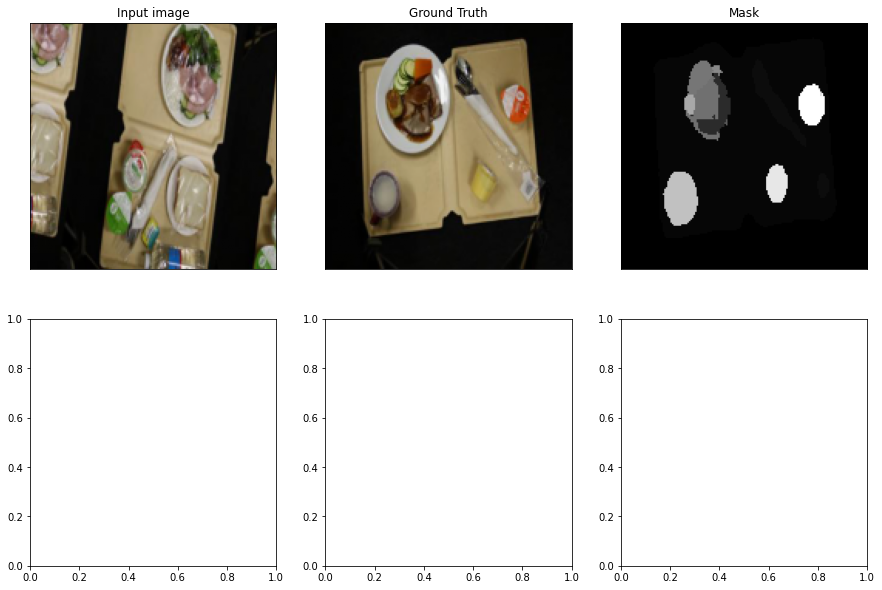

In [157]:
from matplotlib import pyplot as plt
from PIL.ImageOps import autocontrast
from skimage.io import imread
from skimage.transform import resize

i = 0 # validation image index to display results 

f, axs = plt.subplots(2, 3, figsize=(15, 10))

img1 = imread(train_img_paths[i])
img1 = resize(img1, (160, 160))
img2 = autocontrast(load_img(test_img_paths[i]))
img2 = resize(np.array(img2), (160, 160))
img3 = np.argmax(val_preds[i], axis=-1)

axs[0][0].imshow(img1)
axs[0][0].set_title('Input image')
axs[0][0].set_xticks([])
axs[0][0].set_yticks([])

axs[0][1].imshow(img2)
axs[0][1].set_title('Ground Truth')
axs[0][1].set_xticks([])
axs[0][1].set_yticks([])

axs[0][2].imshow(img3, cmap="gray")
axs[0][2].set_title('Mask')
axs[0][2].set_xticks([])
axs[0][2].set_yticks([])

background = imread(train_img_paths[i])
background = resize(background, (160, 160))

axs[1][0].imshow(background)
axs[1][0].imshow(img2, alpha=0.5)
axs[1][0].set_title('GroundTruth overlaying on input')
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])

background = imread(train_img_paths[i])
background = resize(background, (160, 160))
mask = np.argmax(val_preds[i], axis=-1)

axs[1][1].imshow(background)
axs[1][1].imshow(mask, alpha=0.5)
axs[1][1].set_title('Mask overlay input ')
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])

background = autocontrast(load_img(val_target_img_paths[i]))
background = resize(np.array(background), (160, 160))
mask = np.argmax(val_preds[i], axis=-1)

axs[1][2].imshow(background)
axs[1][2].imshow(mask, alpha=0.5)
axs[1][2].set_title('Mask overlay on GT')
axs[1][2].set_xticks([])
axs[1][2].set_yticks([])

plt.show()

*   Read the test mask images to create the ground truth

In [152]:
# solution



*   For each validation image, find the jaccard similarity score

In [158]:
# solution

from skimage.io import imread
from skimage.transform import resize
from skimage.util import img_as_int
from sklearn.metrics import jaccard_score

g_t = img_as_int(resize(imread(test_img_paths[0], as_gray=True), img_size))

print(jaccard_score(g_t.flatten(), mask.flatten(), average='micro'))

0.0


*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter? 
*   Which parameter is used for what type of problem?

**Solution**

*(Double-click or enter to edit)*

...

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

In [ ]:
# solution



*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

*(Double-click or enter to edit)*

...

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [ ]:
# solution



*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

*(Double-click or enter to edit)*

...

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

*(Double-click or enter to edit)*

...

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**

*(Double-click or enter to edit)*

...

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

*(Double-click or enter to edit)*

...

*   What is upsampling?

**Solution**

*(Double-click or enter to edit)*

...

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

*(Double-click or enter to edit)*

...

*   What are some applications of U-Net?

**Solution**

*(Double-click or enter to edit)*

...

*   What are the other popular semantic segmentation algorithms?
*   How are they different from each other?

**Solution**

*(Double-click or enter to edit)*

...

*   What are the popular semantic segmentation datasets which are available for public access?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P5_2: Image Segmentation using UNet**
Deadline for P5_2 submission in CampusVirtual is: **Thursday, the 22nd of December, 2022**